{0: 'started_school', 1: 'finished_school', 2: 'started_work', 3: 'new_family_member', 4: 'bought_house', 5: 'got_married'}
----------------------------


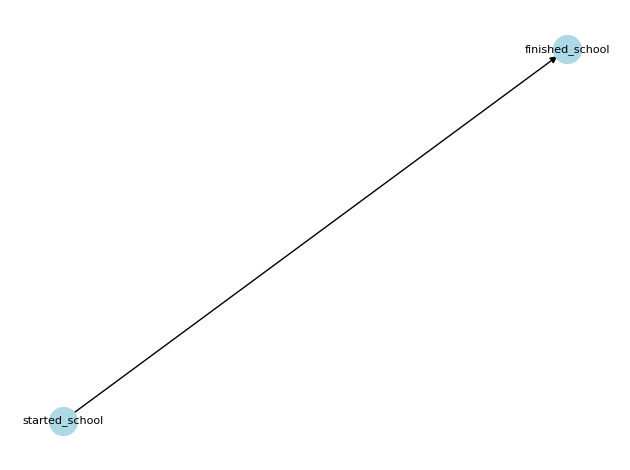

In [ ]:

from classes.event_graph import EventGraph
from classes.event_node import EventNode
from data.event_types import event_types

n1 = EventNode(event_types[0])
n2 = EventNode(event_types[1])

print("----------------------------")

eg = EventGraph()
eg.add_node(n1)
eg.add_node(n2)
eg.add_edge(n1, n2)
eg.visualize()